# Scraping [IKEA](https://www.ikea.com/fr/fr/campaigns/les-indispensables-a-petits-prix-pub0d9cd6c0?icid=fr|20210315|menu|indispensables).

## Initialisation

In [ ]:
import time
import random
import re
import pandas as pd
import numpy as numpy
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from selenium import webdriver 
from selenium.webdriver.common.keys import Keys
from pymongo import MongoClient

In [ ]:
browser = webdriver.Chrome("C:/driver_selenium/chromedriver.exe")

url_to_scrap = "https://www.ikea.com/fr/fr/campaigns/les-indispensables-a-petits-prix-pub0d9cd6c0?icid=fr|20210315|menu|indispensables"

browser.get(url_to_scrap)

# Click to accept cookies
time.sleep(2)
accept_cookie_button = browser.find_element_by_css_selector('#onetrust-accept-btn-handler')
accept_cookie_button.click()

## Parcourir un site

In [ ]:
def random_sleep() :
    ''' Pause aléatoire de maximum 3 secondes '''
    random_number = random.random() * 3 # entre 0 et 3 secondes
    time.sleep(random_number)

In [ ]:
def get_products(browser, title):
    elements = browser.find_elements_by_css_selector('.range-revamp-product-compact')
    data_elements = []
    for elt in elements:
        data_element = {}
        data_element['title'] = title
        data_element['brand'] =  elt.find_element_by_class_name('range-revamp-header-section__title--small').text
        data_element['price'] = elt.find_element_by_class_name('range-revamp-price').text
        data_element['name'] = elt.find_element_by_class_name('range-revamp-header-section__description-text').text
        data_element['rating'] = elt.find_element_by_class_name('range-revamp-average-rating').get_attribute('aria-label')
        data_element['comments'] = elt.find_element_by_class_name('range-revamp-average-rating__reviews').text

        data_element['price'] = float(re.findall('([\d+,]+)', data_element['price'])[0].replace(',','.'))
        data_element['comments'] = int(data_element['comments'].strip('()'))
        data_element['rating'] = float(re.findall('Avis:\s([\d+.]+)', data_element['rating'])[0].replace(',','.'))
        data_elements.append(data_element)

    return data_elements

In [ ]:
def parse_urls() :
    ''' Clique sur les urls '''
    print("Browsing...")

    selector_css = ".c130l69h .hqs7k6k > a"
    links = browser.find_elements_by_css_selector(selector_css)

    data_list = []

    for index in range(0, len(links)) :
        random_sleep()
        url = browser.find_elements_by_css_selector(selector_css)[index]
        title = url.text
        url.click()
        # An implicit wait tells WebDriver to poll the DOM for a certain amount of time when trying to find
        # any element (or elements) not immediately available.
        browser.implicitly_wait(10) 
        products = get_products(browser, title)
        data_list = data_list + products
        browser.back()

    print("Browsing done.")

    return data_list

# Execution
IKEA_data = parse_urls()

## MongoDB

In [ ]:
# Connexion MongoDB
try:
    client = MongoClient('localhost', 27017)
    db = client.IKEA_scraping
    products = db.products
except:
    print("Ooups! la connexion n'a pas pu abouti")

In [ ]:
# Envoi vers MongoDB
def export_to_mongo():
    for index, data in enumerate(IKEA_data):
        json_to_import = data
        
        products.insert_one(json_to_import)

#export_to_mongo()

In [ ]:
# Récupération depuis MongoDB
my_products_mongo = products.find({}).limit(12)
[pprint(product) for product in my_products_mongo]

## Récupération des pages

In [ ]:
# Récupérer tous les 'title'
all_title = products.distinct("title")
pprint(all_title)

## Le produit le mieux noté pour chaque page

In [ ]:
# Le produit le mieux noté pour chaque page
highest_rating = []

for title in all_title:
    match = {
        "$match": {"title": title}
    }
    project = {"$project": {"_id": 0}}
    limit = {"$limit": 1}
    sort = {
        "$sort": {"rating": -1}
    }

    highest_rating.append(list(products.aggregate([match, project, sort, limit]))[0])

[product for product in highest_rating]

## La moyenne des prix pour chaque page

In [ ]:
# La moyenne des prix pour chaque page
group = {
    "$group": {"_id": "$title", "average": {"$avg": "$price"}}
}
sort = {
    "$sort": {"price": -1}
}

average_price = products.aggregate([group, sort])

[average for average in average_price]

## La quantité de produit dans une page

In [ ]:
# La quantité de produit dans une page
group = {
    "$group": {"_id": "$title", "quantity": {"$sum": 1}}
}
sort = {
    "$sort": {"quantity": -1}
}

quantities = products.aggregate([group, sort])

[quantity for quantity in quantities]

## Afficher les produits dans un DataFrame

In [ ]:
df = pd.DataFrame(IKEA_data)

## Supprimer la colonne des ID

In [ ]:
data = df.drop(['_id'], axis=1)
data.head()

In [ ]:
data['brand'].value_counts().sum()

## Moyenne des prix, notes, et nombre de commentaires par page

<AxesSubplot:title={'center':'Moyenne des prix, notes, et nombre de commentaires par page'}, xlabel='title'>

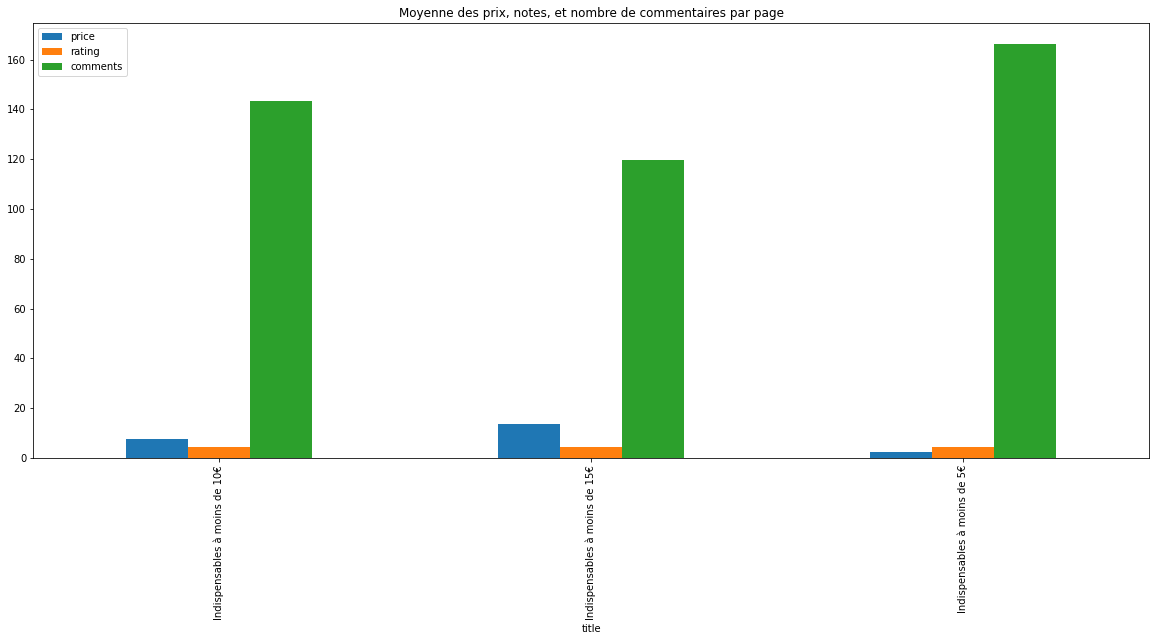

In [78]:
data_mean = data.groupby(['title']).mean()
data_mean.plot.bar(x=None, y=None, figsize=(20,8), title="Moyenne des prix, notes, et nombre de commentaires par page")

## Seaborn

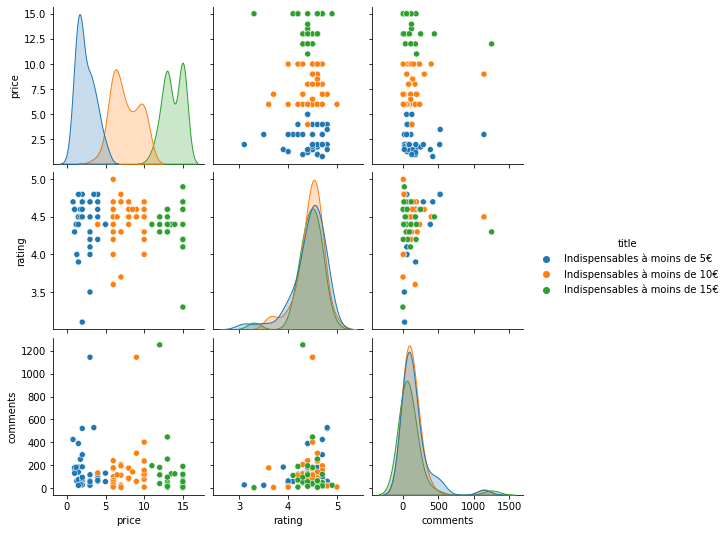

In [79]:
sns.pairplot(data, hue='title')

# *TODO* 
 peut-être ajouter plus de graphes camemberts ou autres demain on fera ça le matin histoire de tuer le temps